# Se realizará un análisis de la base de datos de autos detectados.

In [15]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


Calculo de tipo de vehiculo detectado durante el dia

In [16]:
# Conectarce a la base de datos
conn = sqlite3.connect('vehicle_detections.db')

# Crear un cursor para ejecutar consultas
query = "SELECT vehicle_type, COUNT(*) as count FROM vehicle_detections GROUP BY vehicle_type"
df = pd.read_sql_query(query, conn)

# Cerrar la conexión
conn.close()
#Imprimir la cantidad de autos de cada tipo
print(df)

  vehicle_type  count
0          bus    471
1          car  12793
2   motorcycle      5
3        truck   1055


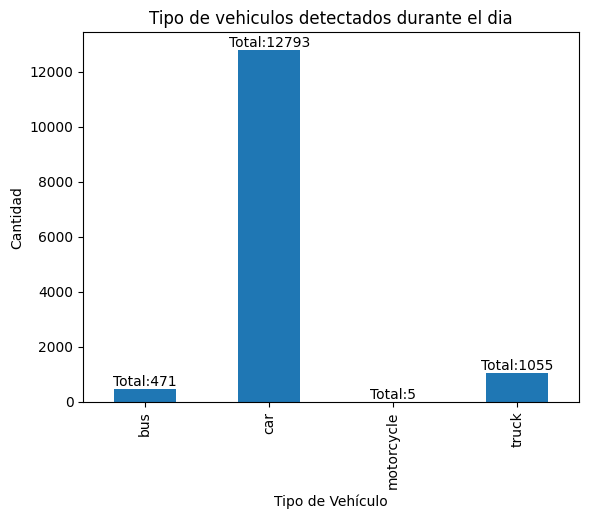

In [24]:
# Graficar los resultados de la consulta la cual es un histograma de los tipos de vehículos detectados durante todo el dia
ax=df.plot(x='vehicle_type', y='count', kind='bar', legend=False)
plt.xlabel('Tipo de Vehículo')
plt.ylabel('Cantidad')
plt.title('Tipo de vehiculos detectados durante el dia')
# Anotar el número total de vehículos en cada barra del gráfico
for i, count in enumerate(df['count']):
    ax.annotate(f'\nTotal:{count}', (i, count), ha='center', va='bottom')

plt.show()

Calculo de tipo de vehiculo detectado por hora

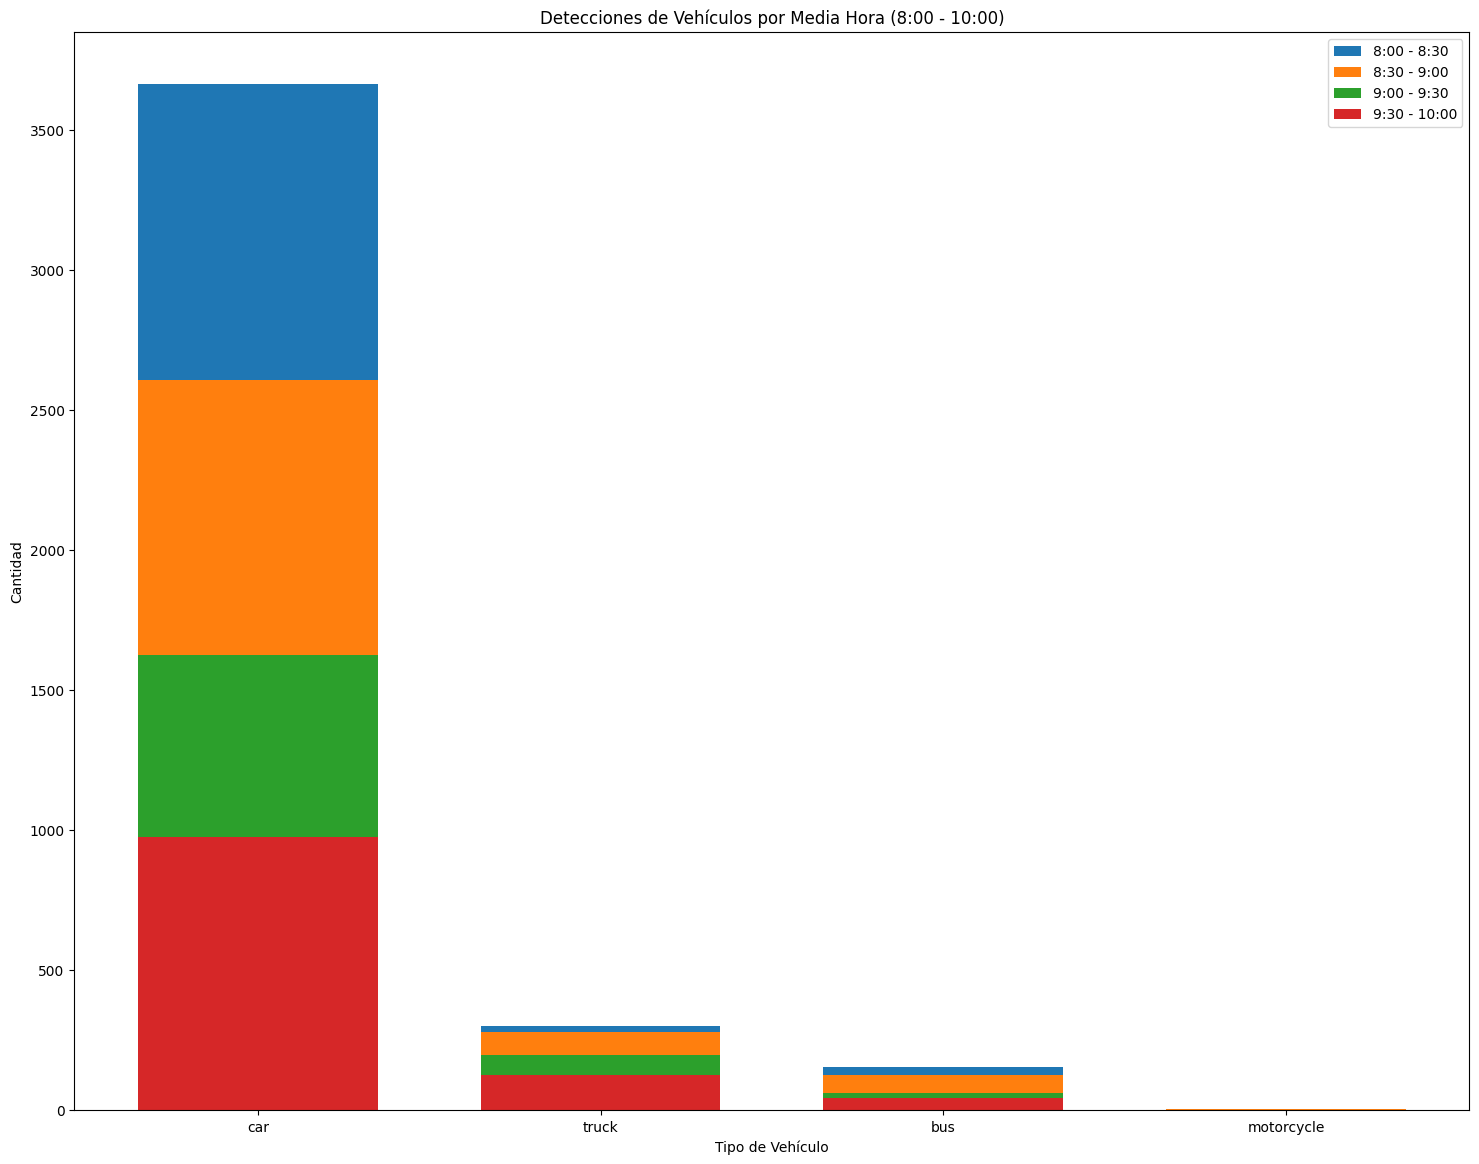

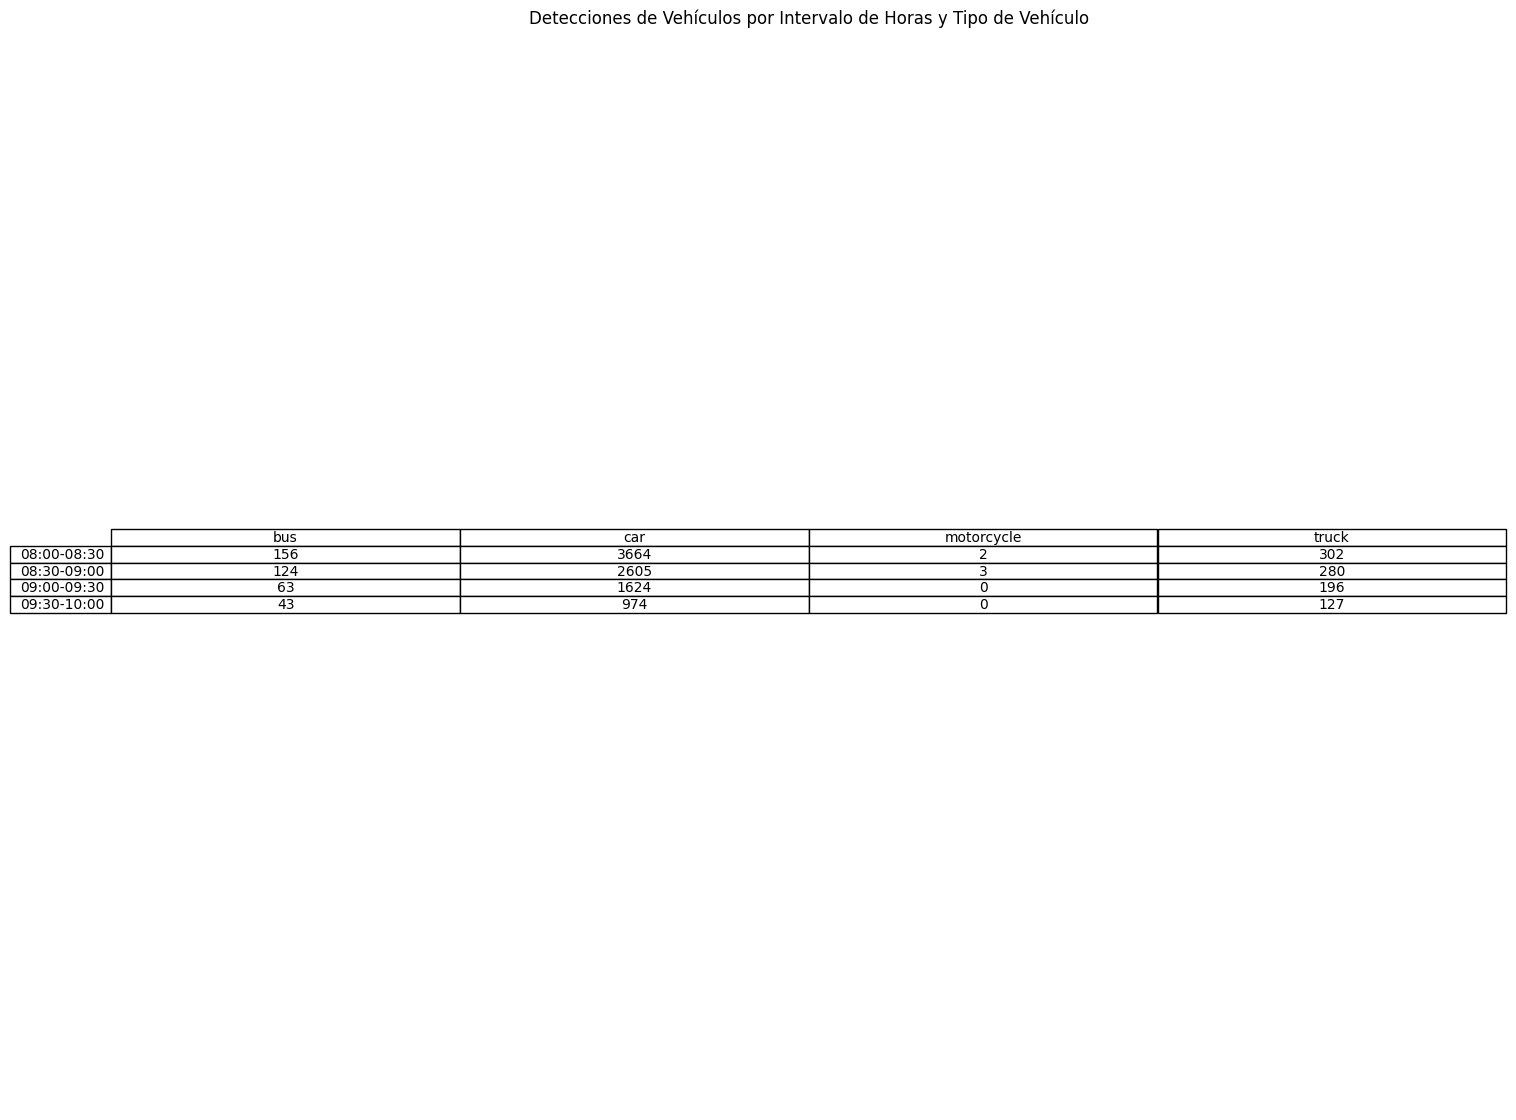

In [25]:

# Conectarse a la base de datos y ejecutar la consulta
conn = sqlite3.connect('vehicle_detections.db')
query = "SELECT vehicle_type, detection_time FROM vehicle_detections"
df = pd.read_sql_query(query, conn)

# Convertir la columna detection_time a tipo datetime
df['detection_time'] = pd.to_datetime(df['detection_time'])

# Agregar una columna de media hora
df['half_hour'] = (df['detection_time'].dt.hour * 2) + (df['detection_time'].dt.minute >= 30)

# Cerrar la conexión
conn.close()

# Graficar los resultados por media hora
plt.figure(figsize=(18, 14))
for half_hour in range(16, 20):
    # Filtrar el DataFrame por el intervalo de media hora actual
    filtered_df = df[(df['half_hour'] >= half_hour) & (df['half_hour'] < half_hour + 1)]

    # Contar la cantidad de vehículos de cada tipo en este intervalo de media hora
    vehicle_counts = filtered_df['vehicle_type'].value_counts()

    # Graficar los resultados
    x = list(vehicle_counts.index)
    y = list(vehicle_counts.values)
    plt.bar(x, y, width=0.7, label=f'{half_hour//2}:00 - {half_hour//2}:30' if half_hour % 2 == 0 else f'{half_hour//2}:30 - {half_hour//2 + 1}:00')


plt.xlabel('Tipo de Vehículo')
plt.ylabel('Cantidad')
plt.title('Detecciones de Vehículos por Media Hora (8:00 - 10:00)')
plt.legend()
plt.show()

# Crear una tabla de frecuencia de vehículos por media hora y tipo de vehículo
table_df = df.groupby(['half_hour', 'vehicle_type']).size().unstack(fill_value=0)

# Eliminar la primera fila de datos de la tabla_df
table_df = table_df.iloc[1:]

time_labels = ['08:00-08:30', '08:30-09:00', '09:00-09:30', '09:30-10:00']
table_df.index = time_labels
# Cerrar la conexión
conn.close()

# Graficar los resultados como tabla
plt.figure(figsize=(18, 14))
plt.table(cellText=table_df.values, rowLabels=table_df.index, colLabels=table_df.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title('Detecciones de Vehículos por Intervalo de Horas y Tipo de Vehículo')
plt.show()


Calculo de tiempo promedio por tipo de vehiculo detectado durante el dia

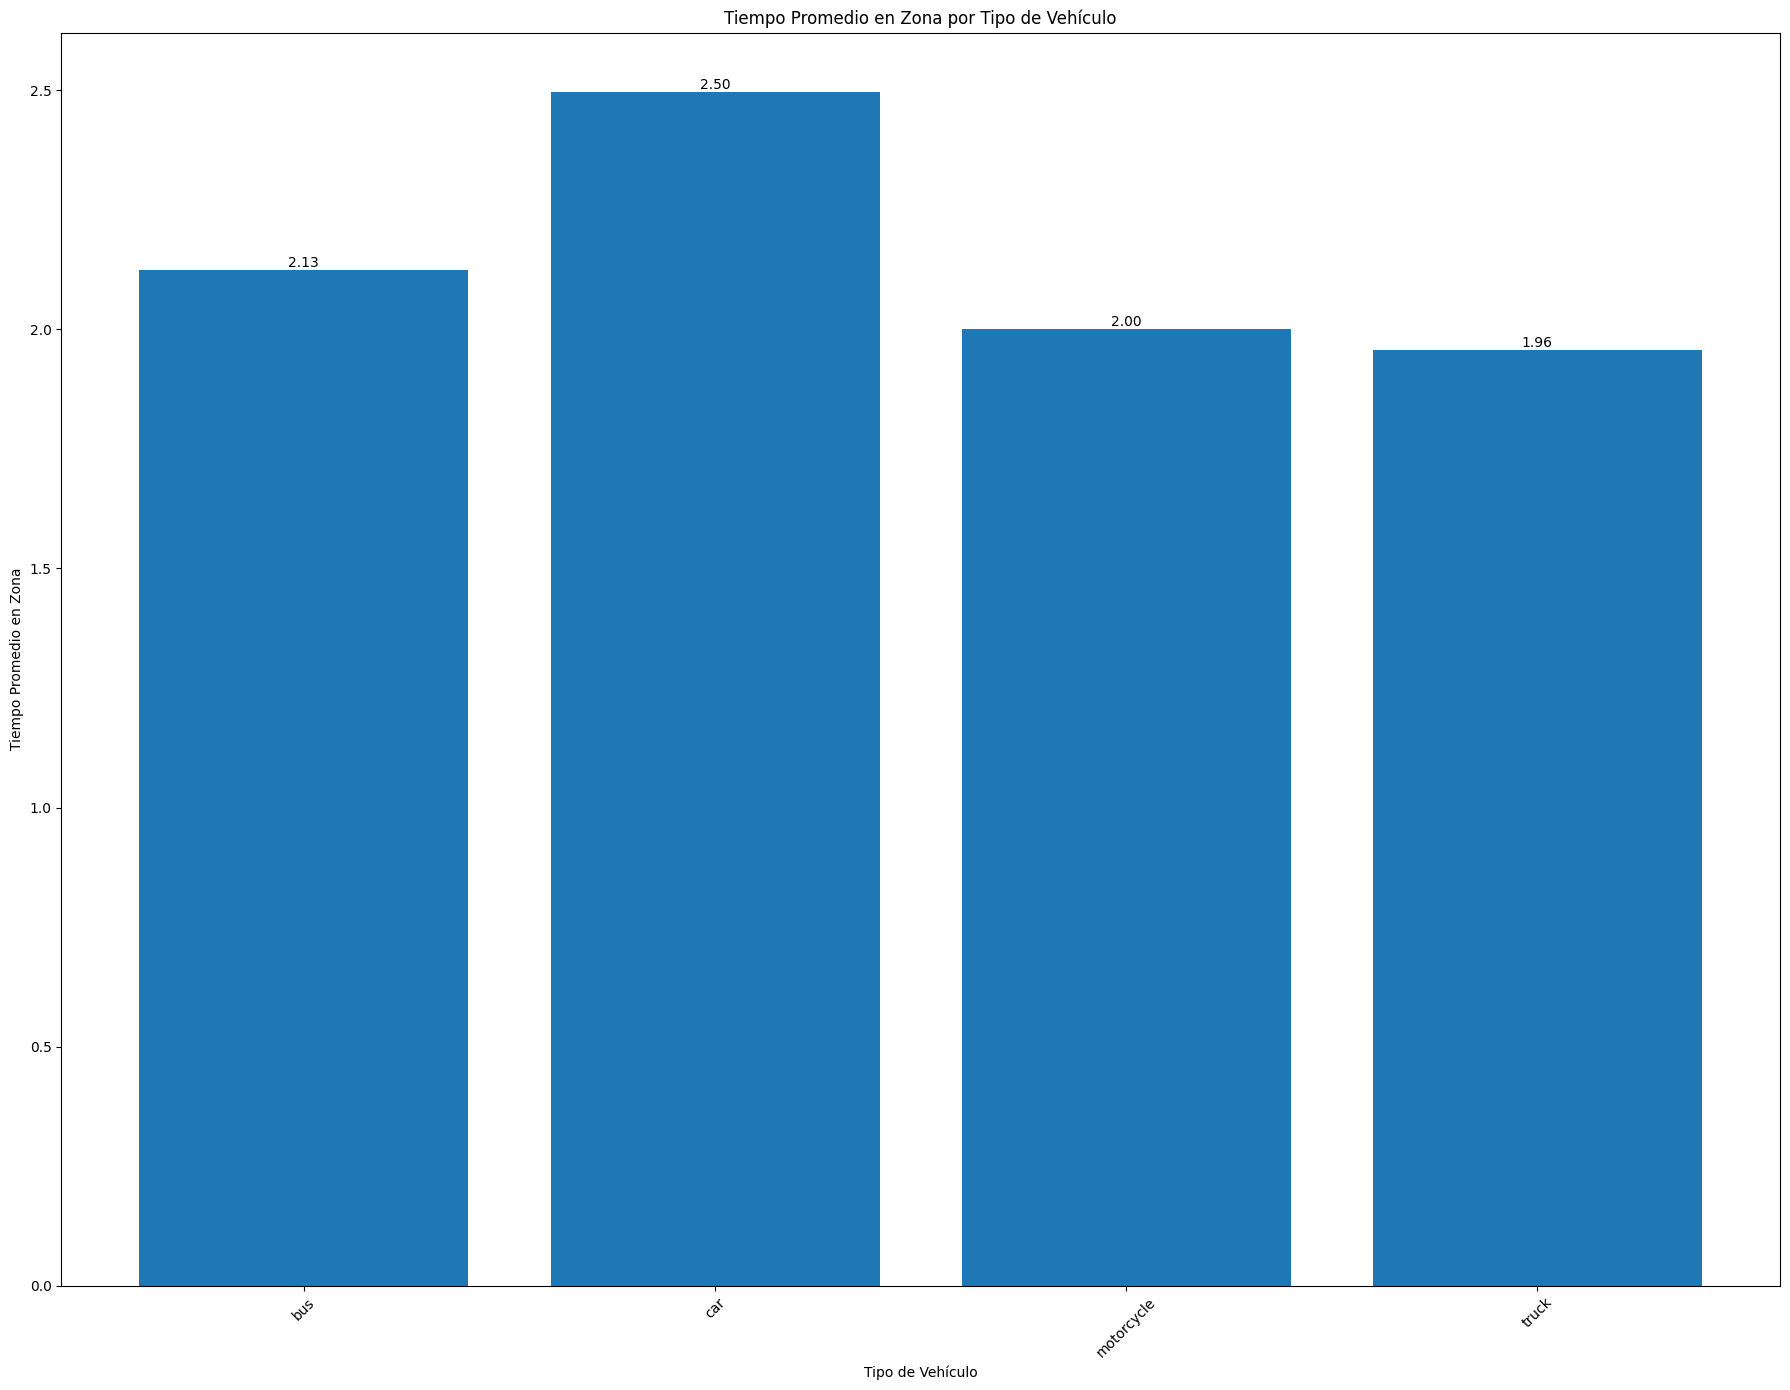

In [26]:
# Conexión a la base de datos
conn = sqlite3.connect('vehicle_detections.db')

# Consulta SQL para obtener los datos
query = """
SELECT vehicle_type, AVG(time_in_zone) as avg_time_in_zone
FROM vehicle_detections
GROUP BY vehicle_type
"""

# Leer datos en un DataFrame
df = pd.read_sql_query(query, conn)

# Cerrar la conexión a la base de datos
conn.close()

# Crear el gráfico de barras
plt.figure(figsize=(18, 14))
plt.bar(df['vehicle_type'], df['avg_time_in_zone'])
plt.xlabel('Tipo de Vehículo')
plt.ylabel('Tiempo Promedio en Zona')
plt.title('Tiempo Promedio en Zona por Tipo de Vehículo')
plt.xticks(rotation=45)
plt.tight_layout()
# Anotar el tiempo promedio sobre cada barra
for i, avg_time in enumerate(df['avg_time_in_zone']):
    plt.text(i, avg_time, f'{avg_time:.2f}', ha='center', va='bottom')
plt.show()


Calculo de tiempo promedio por tipo de vehiculo detectado por hora

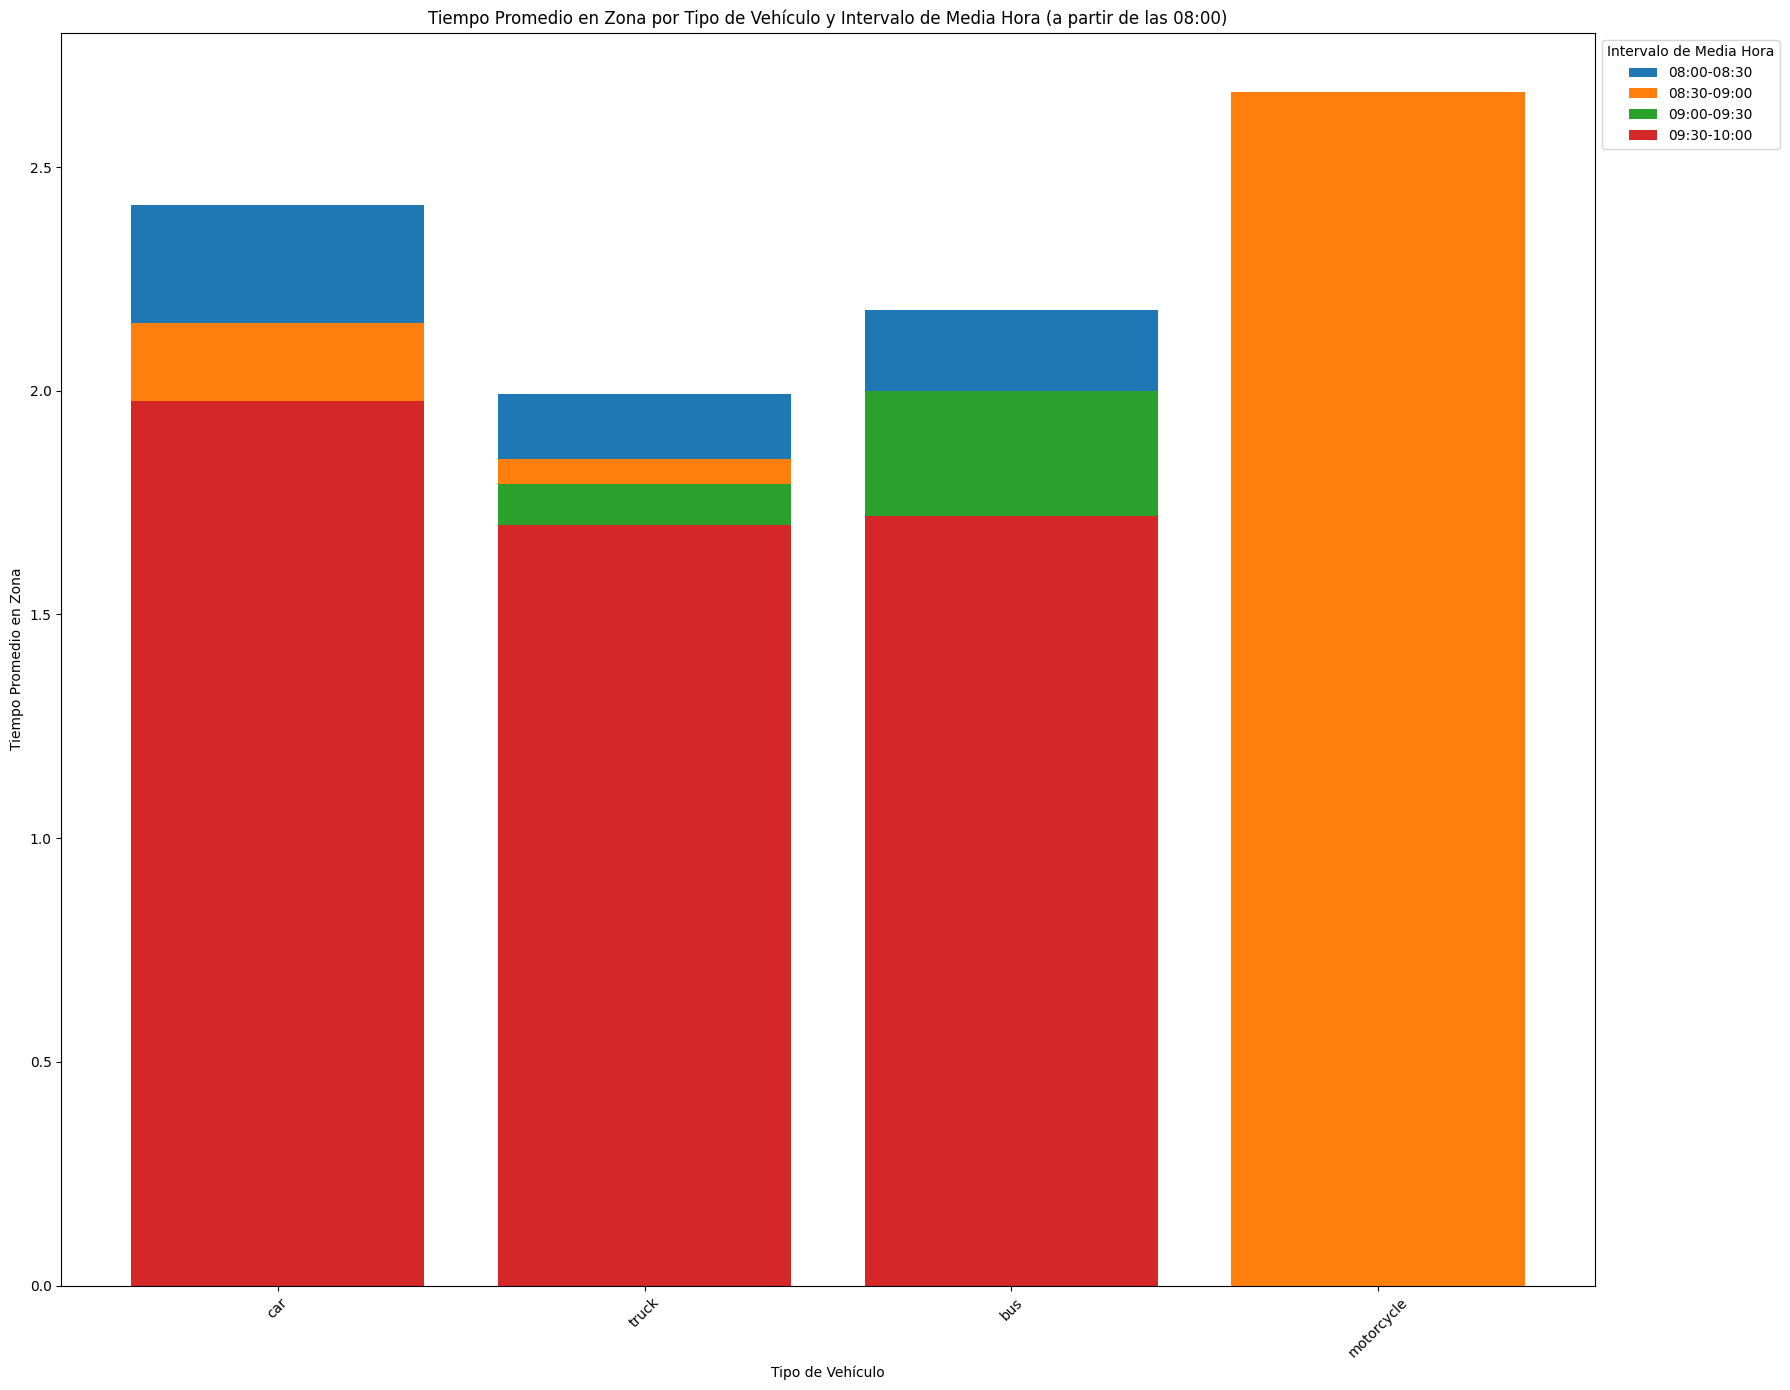

In [27]:
# Conexión a la base de datos
conn = sqlite3.connect('vehicle_detections.db')

# Consulta SQL para obtener los datos por cada media hora y por tipo de vehículo, excluyendo el intervalo de 7:30 a 08:00
query = """
SELECT 
    CASE
        WHEN strftime('%M', detection_time) < '30' THEN strftime('%H', detection_time) || ':00' || '-' || strftime('%H', detection_time) || ':30'
        ELSE strftime('%H', detection_time) || ':30' || '-' || strftime('%H', detection_time, '+1 hour') || ':00'
    END as time_interval,
    vehicle_type,
    AVG(time_in_zone) as avg_time_in_zone
FROM vehicle_detections
WHERE strftime('%H:%M', detection_time) >= '08:00'  -- Excluir el intervalo de 7:30 a 08:00
GROUP BY time_interval, vehicle_type
ORDER BY time_interval, 
         CASE vehicle_type
             WHEN 'car' THEN 1
             WHEN 'truck' THEN 2
             WHEN 'bus' THEN 3
             WHEN 'motorcycle' THEN 4
         END
"""

# Leer datos en un DataFrame
df = pd.read_sql_query(query, conn)
 
# Cerrar la conexión a la base de datos
conn.close()

# Crear el gráfico de barras agrupado por intervalo de media hora y por tipo de vehículo
fig, ax = plt.subplots(figsize=(18, 14))
for time_interval, data in df.groupby('time_interval'):
    ax.bar(data['vehicle_type'], data['avg_time_in_zone'], label=time_interval)

ax.set_xlabel('Tipo de Vehículo')
ax.set_ylabel('Tiempo Promedio en Zona')
ax.set_title('Tiempo Promedio en Zona por Tipo de Vehículo y Intervalo de Media Hora (a partir de las 08:00)')
ax.legend(title='Intervalo de Media Hora', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



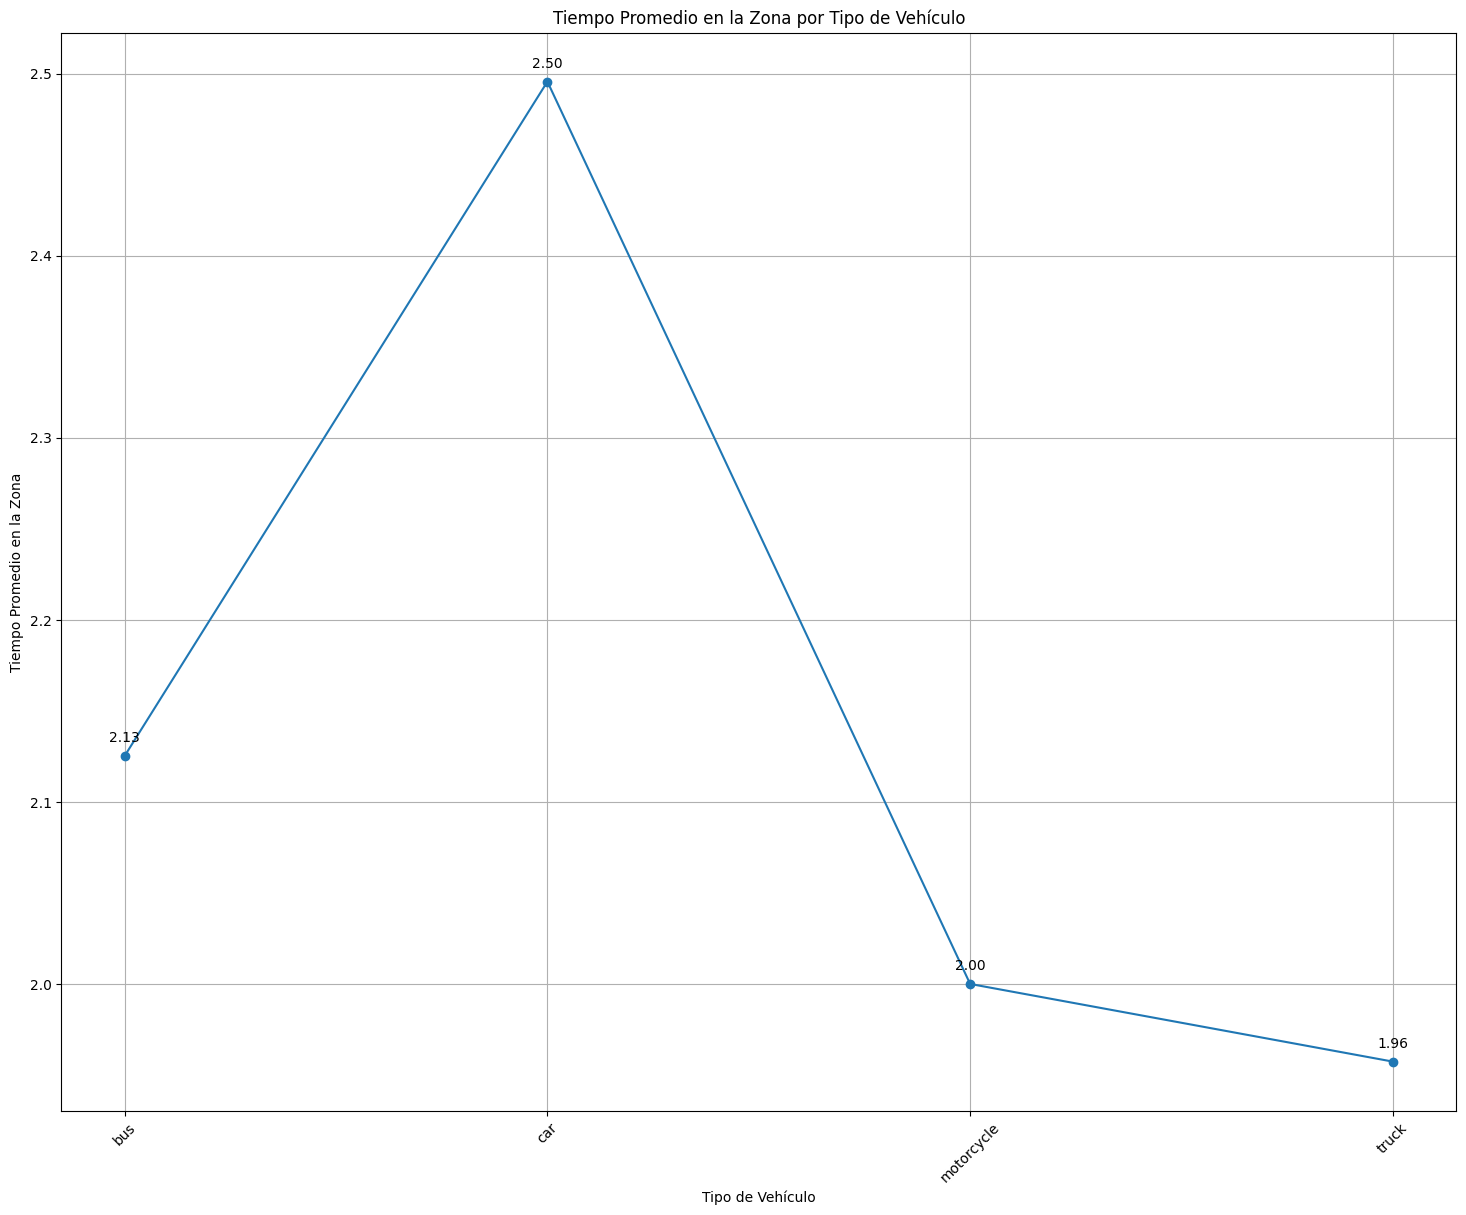

In [28]:
# Conexión a la base de datos
conn = sqlite3.connect('vehicle_detections.db')
cursor = conn.cursor()

# Consulta para obtener los datos de la base de datos
query = "SELECT vehicle_type, AVG(time_in_zone) FROM vehicle_detections GROUP BY vehicle_type"
cursor.execute(query)
data = cursor.fetchall()

# Separar los resultados en listas para el gráfico
vehicle_types = [row[0] for row in data]
avg_times = [row[1] for row in data]
plt.figure(figsize=(18, 14))
# Mostrar tiempo promedio de cada punto
for i, txt in enumerate(avg_times):
    plt.annotate(f'{txt:.2f}', (vehicle_types[i], avg_times[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Crear el gráfico de líneas
plt.plot(vehicle_types, avg_times, marker='o')
plt.xlabel('Tipo de Vehículo')
plt.ylabel('Tiempo Promedio en la Zona')
plt.title('Tiempo Promedio en la Zona por Tipo de Vehículo')
plt.xticks(rotation=45)
plt.grid(True)

# Mostrar el gráfico
plt.show()


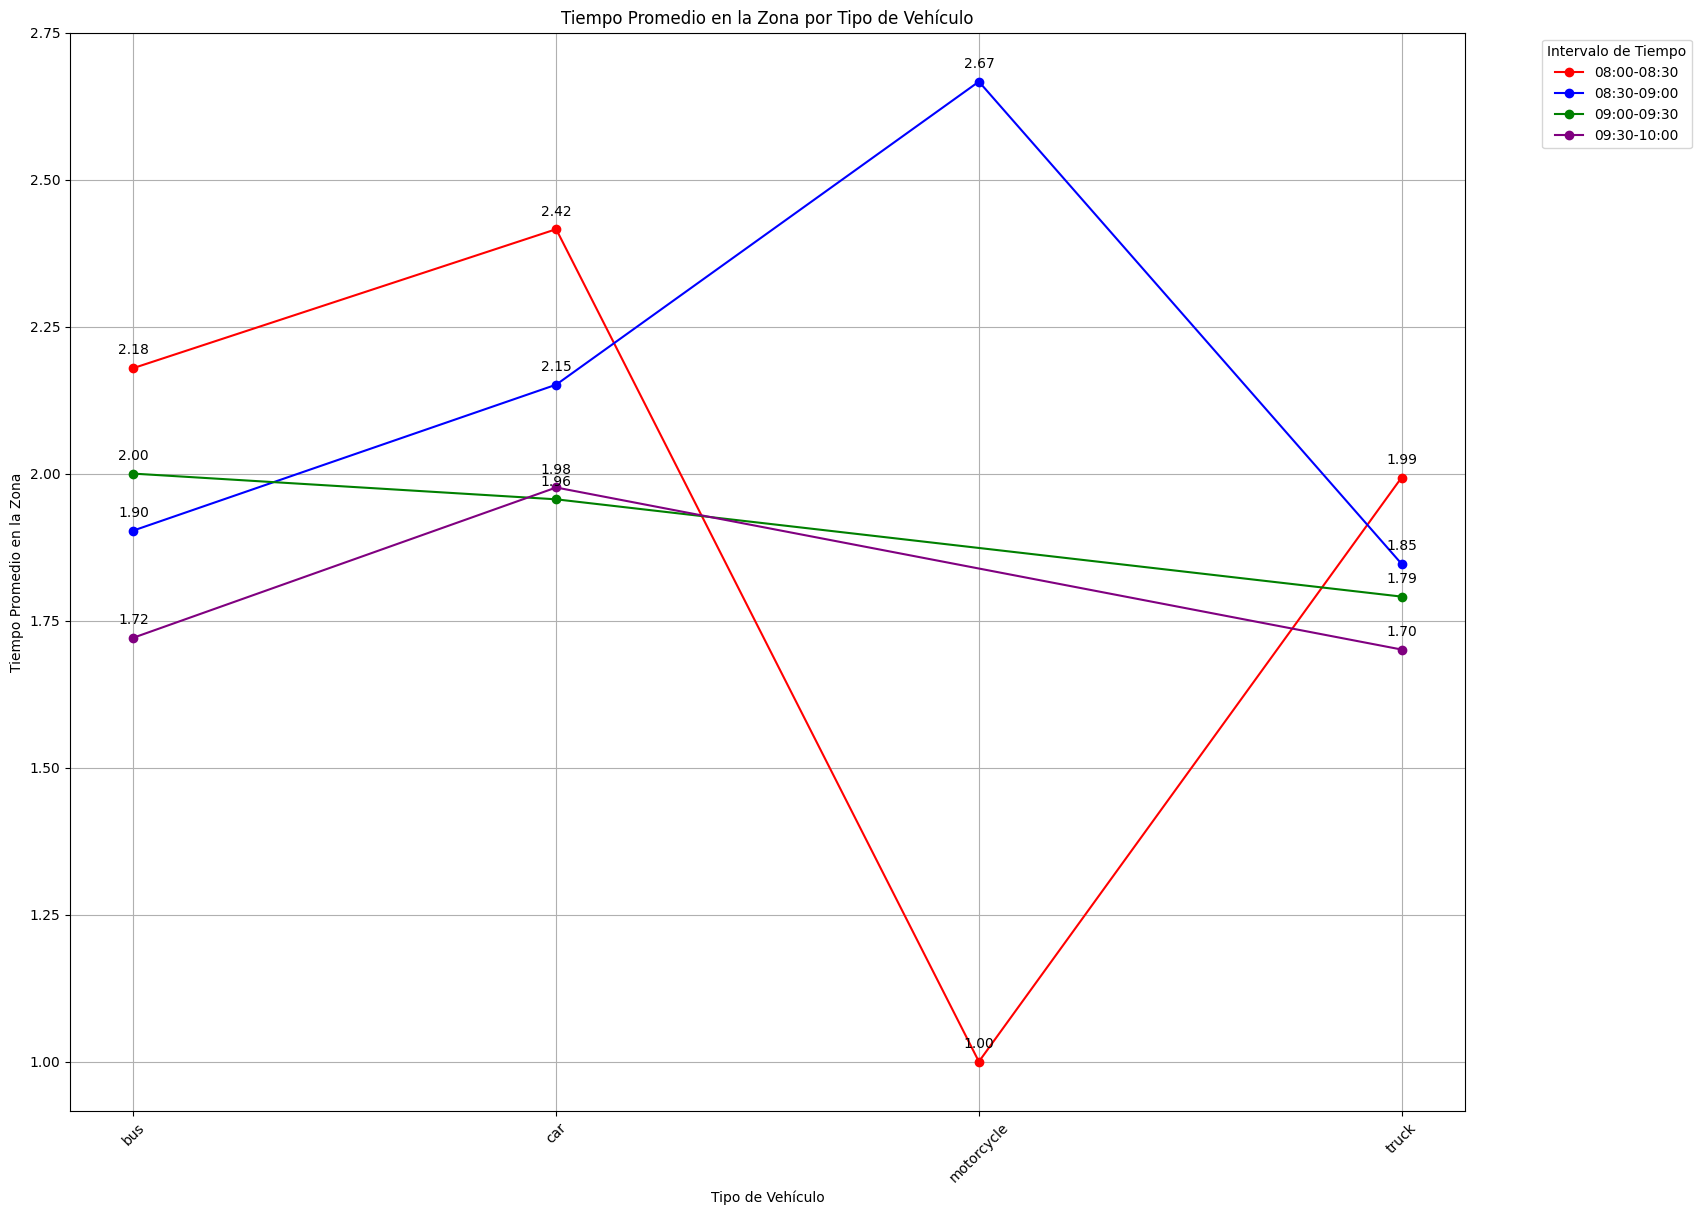

In [29]:

# Conexión a la base de datos
conn = sqlite3.connect('vehicle_detections.db')
cursor = conn.cursor()

# Consulta para obtener los datos de la base de datos y agrupar por intervalo de 30 minutos
query = """
    SELECT vehicle_type,
           AVG(time_in_zone),
           CASE
               WHEN strftime('%M', detection_time) BETWEEN '00' AND '29' THEN strftime('%H', detection_time) || ':00-'
                                                                                || strftime('%H', detection_time) || ':30'
               WHEN strftime('%M', detection_time) BETWEEN '30' AND '59' THEN strftime('%H', detection_time) || ':30-'
                                                                                || strftime('%H', detection_time, '+1 hour') || ':00'
           END AS time_interval
    FROM vehicle_detections
    WHERE strftime('%H', detection_time) >= '08' AND strftime('%H', detection_time) < '10'
    GROUP BY vehicle_type, time_interval
"""
cursor.execute(query)
data = cursor.fetchall()

# Crear un diccionario para almacenar los promedios de tiempo por intervalo
interval_averages = {}

# Iterar sobre los datos y almacenar los promedios en el diccionario
for row in data:
    vehicle_type = row[0]
    avg_time = row[1]
    time_interval = row[2]
    if time_interval not in interval_averages:
        interval_averages[time_interval] = {'vehicle_types': [], 'avg_times': []}
    interval_averages[time_interval]['vehicle_types'].append(vehicle_type)
    interval_averages[time_interval]['avg_times'].append(avg_time)

# Colores o estilos de línea para cada intervalo de tiempo
colors = {'08:00-08:30': 'red', '08:30-09:00': 'blue', '09:00-09:30': 'green', '09:30-10:00': 'purple'}

# Crear el gráfico de líneas con colores o estilos de línea diferentes para cada intervalo de tiempo
plt.figure(figsize=(18, 14))  # Tamaño de la imagen
for interval, data in interval_averages.items():
    vehicle_types = data['vehicle_types']
    avg_times = data['avg_times']
    color = colors[interval] if interval in colors else 'black'  # Color predeterminado para intervalos desconocidos
    plt.plot(vehicle_types, avg_times, marker='o', color=color, label=interval)
    
    # Mostrar el tiempo promedio en cada punto
    for i, txt in enumerate(avg_times):
        plt.annotate(f'{txt:.2f}', (vehicle_types[i], avg_times[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Configuración del gráfico
plt.xlabel('Tipo de Vehículo')
plt.ylabel('Tiempo Promedio en la Zona')
plt.title('Tiempo Promedio en la Zona por Tipo de Vehículo')
plt.xticks(rotation=45)
plt.legend(title='Intervalo de Tiempo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Mostrar el gráfico
plt.show()
